In [1]:
import os
import unicodedata
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, trim, percentile_approx, udf, when, broadcast, size, regexp_replace, lower, pandas_udf
from pyspark.sql.types import StringType, DoubleType, FloatType, ArrayType
import inflect
import pandas as pd

import json
import sys
from argparse import ArgumentParser
from typing import List
import pandas as pd
import re
import inflect
from ingredient_parser import parse_ingredient
import traceback
import nltk
try:
    from nltk.corpus import wordnet as wn
    wn.synsets('test')
except LookupError:
    nltk.download('wordnet')

# from openfoodfacts import API
# api = API(user_agent="keto_checker/1.0") # Create OFF API instance
# import pandas as pd

try:
    from sklearn.metrics import classification_report
except ImportError:
    # sklearn is optional
    def classification_report(y, y_pred):
        print("sklearn is not installed, skipping classification report")

import sys, os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, trim, median, count, lit, avg, percentile_approx, udf, when, broadcast, sum as spark_sum, size, explode, split, regexp_replace, lower
from pyspark.sql.types import StringType, DoubleType, FloatType, BooleanType
import unicodedata

from diet_constants import (
    non_vegan_ingredients,
    food_measurements_description,
    food_categories,
    non_vegan_categories
)

from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from gensim.models import KeyedVectors
import glob


In [2]:
spark = (
    SparkSession.builder
    .appName("KetoChecker")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "2g")
    .getOrCreate()
)



print("Current working directory:", os.getcwd())
food = spark.read.parquet(os.path.abspath(os.path.join(os.getcwd(), 'df_food_parsed.parquet')))
food.show(5)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/28 18:37:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Current working directory: /usr/src/app


+--------------------+------------------+
|        product_name|carbohydrates_100g|
+--------------------+------------------+
|mt olive sweet n ...|             32.14|
|    watermelon chunk|         7.4204946|
|  jumbo whole cashew|             102.0|
|        garden salad|          3.649635|
|  skim fat free milk|         5.4166665|
+--------------------+------------------+
only showing top 5 rows


In [3]:
# ing = spark.read.parquet(os.path.abspath(os.path.join(os.getcwd(), 'OpenSearch_exploded_unique.parquet')))
# ing.show(5)
# ing_pd = ing.select("ingredient_str").toPandas()

In [4]:
# convert to Pandas
food_pd = food.select("product_name").toPandas()

In [5]:
# # Compute embeddings
# model = SentenceTransformer("all-MiniLM-L6-v2")
# ingredient_embeddings = model.encode(ing_pd['ingredient_str'].tolist(), show_progress_bar=True, normalize_embeddings=True)
# food_embeddings = model.encode(food_pd['product_name'].tolist(), show_progress_bar=True, normalize_embeddings=True)


In [5]:
# Load FoodBERT or another domain BERT
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

In [6]:
food_pd['word_count'] = food_pd['product_name'].apply(lambda s: len(s.split()))
print("Max words:", food_pd['word_count'].max())
print("Sample longest string (words):", food_pd.loc[food_pd['word_count'].idxmax(), 'product_name'])

Max words: 99
Sample longest string (words): pour 1 portion 167 g calorie 30 potassium 30 mg valeur nutritive sodium 110 mg calcium 50 mg nutrition fact per 1 portion 167 g carbohydrate glucide 1 saturated sature 15g 2025al09 1828 li1921h tran tran 01 g fibre fibre 0 g protein proteine 2 g sugar sucre 0 g a lot5 ou moin fat lipide 20g portion fibre fibre 0 g iron fer 0 mg 2025alo9 1828 li1921h sugar sucre 0 g fat lipide 20 g saturated sature 15g fat ipide 20 g sugarssucre 0 g cholesterol cholesterol transtran 01 g cholesterol cholesterol valeur protein proteine 2 g


In [7]:
def token_count(s):
    return len(tokenizer.encode(s, add_special_tokens=True))

food_pd['token_count'] = food_pd['product_name'].apply(token_count)
print("Max tokens:", food_pd['token_count'].max())
print("Sample longest string (tokens):", food_pd.loc[food_pd['token_count'].idxmax(), 'product_name'])

Max tokens: 154
Sample longest string (tokens): pour 1 portion 167 g calorie 30 potassium 30 mg valeur nutritive sodium 110 mg calcium 50 mg nutrition fact per 1 portion 167 g carbohydrate glucide 1 saturated sature 15g 2025al09 1828 li1921h tran tran 01 g fibre fibre 0 g protein proteine 2 g sugar sucre 0 g a lot5 ou moin fat lipide 20g portion fibre fibre 0 g iron fer 0 mg 2025alo9 1828 li1921h sugar sucre 0 g fat lipide 20 g saturated sature 15g fat ipide 20 g sugarssucre 0 g cholesterol cholesterol transtran 01 g cholesterol cholesterol valeur protein proteine 2 g


<Axes: >

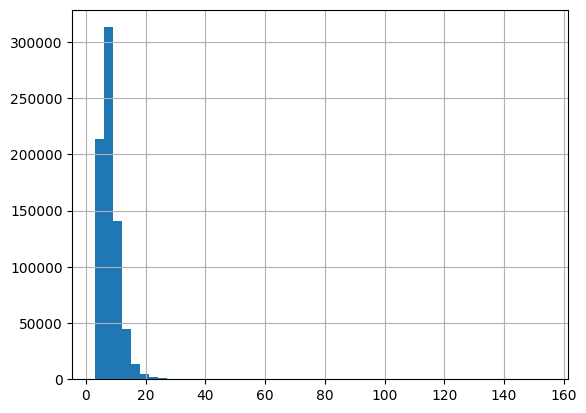

In [8]:
food_pd['token_count'].hist(bins=50)

In [9]:
food_pd.head()

,product_name,word_count,token_count
0,mt olive sweet n hot salad pepper,7,9
1,watermelon chunk,2,6
2,jumbo whole cashew,3,7
3,garden salad,2,4
4,skim fat free milk,4,7


In [10]:
food_pd.sort_values('word_count').tail(50)

,product_name,word_count,token_count
366008,nashville inspired hot chicken hot seasoned wh...,32,39
189054,blueberry chia peach with matcha granola roast...,32,45
435646,restaurant-style pad thai with rice noodle chi...,32,50
162142,chicken tortilla green cabbage chili lime whit...,32,43
51885,organic santa fe style salad with chicken roma...,32,39
437697,classic assorted chocolate milk chocolate peca...,32,47
616869,mini pop watermelon strawberry orange creme bl...,32,40
67456,mini classic pop watermelon blue razz bubble g...,33,41
254455,medium traditional sausage pepperoni seasoned ...,33,37
419924,margherita recipe crispy thin crust pizza topp...,33,51


In [11]:
food_pd.query("product_name.str.contains('pizza crust|crust pizza', case=False, na=False)", engine='python')


,product_name,word_count,token_count
520,4 cheese blend rising crust pizza,6,8
532,pepperoni thin crust pizza,4,7
654,dr oetker virtuoso thin crispy crust pizza sig...,9,18
1271,pizzeria style medium crust pizza,5,9
1648,dr oetker ristorante thin crust pizza vegetable,7,13
...,...,...,...
726967,crisp crust pizza mexican style,5,7
727318,pillsbury classic pizza crust dough 2 pack,7,10
729862,cauliflower pizza crust mix,4,8
729970,bbq chicken stuffed crust pizza,5,8


In [12]:
food_pd.count()

product_name    734247
word_count      734247
token_count     734247
dtype: int64

In [13]:
# food_pd = food_pd[food_pd['word_count']<21]

In [14]:
# food_pd.count()

In [15]:

# def get_bert_embedding(text):
#     inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=32)
#     outputs = model(**inputs)
#     # Option 1: use [CLS] token
#     return outputs.last_hidden_state[0, 0, :].detach().numpy()
#     # Option 2: mean pooling (sometimes better for similarity)
#     # return outputs.last_hidden_state.mean(dim=1)[0].detach().numpy()

# ingredient_embeddings = np.vstack([get_bert_embedding(x) for x in ing_pd['ingredient_str']])
# food_embeddings = np.vstack([get_bert_embedding(x) for x in food_pd['product_name']])

In [16]:
# import time

# def get_bert_embeddings_batch(texts, batch_size=120):
#     all_vecs = []
#     model.eval()
#     total = len(texts)
#     num_batches = (total + batch_size - 1) // batch_size

#     start_total = time.time()
#     batch_times = []
#     with torch.no_grad():
#         for i in range(0, total, batch_size):
#             start = time.time()
#             batch = texts[i:i+batch_size]
#             inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=32)
#             outputs = model(**inputs)
#             batch_vecs = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # [CLS]
#             all_vecs.append(batch_vecs)
#             end = time.time()
#             batch_times.append(end - start)
#             print(f"Batch {i//batch_size + 1}/{num_batches} took {end - start:.2f} sec")
#             if i == 0:
#                 # Print a rough estimate after first batch
#                 est_total = (end - start) * num_batches
#                 print(f"Estimated total time: {est_total/60:.1f} minutes")

#     end_total = time.time()
#     print(f"Actual total time: {(end_total - start_total)/60:.1f} minutes")
#     print(f"Average batch time: {sum(batch_times)/len(batch_times):.2f} sec")
#     return np.vstack(all_vecs)


In [19]:
# from time import time
import time

In [24]:

def get_bert_embeddings_batch(
    texts,
    batch_size=120,
    save_every=1000,   # <-- Save every 1000 batches
    print_every=1000,
    out_dir="embeddings_checkpoints",
    start_idx=0
):
    os.makedirs(out_dir, exist_ok=True)
    all_vecs = []
    all_names = []
    model.eval()
    total = len(texts)
    num_batches = (total + batch_size - 1) // batch_size

    # Checkpoint resume logic (optional, simple version: doesn't reload partial parquet files)
    # You can add more robust logic here if you want to resume from last saved file.

    start_total = time.time()
    batch_times = []
    for batch_num, i in enumerate(range(start_idx, total, batch_size)):
        start = time.time()
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=32)
        outputs = model(**inputs)
        batch_vecs = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy() # [CLS]
        all_vecs.append(batch_vecs)
        all_names.extend(batch)  # Product names for this batch
        end = time.time()
        batch_times.append(end - start)

        # Print for the first batch and every print_every
        if batch_num == 0 or batch_num % print_every == 0:
            est_total = (end - start) * (num_batches - batch_num)
            print(f"Batch {batch_num+1}/{num_batches} took {end - start:.2f} sec")
            print(f"Estimated time left: {est_total/60:.1f} minutes")

        # Save every save_every batches
        if (batch_num + 1) % save_every == 0:
            # Flatten the accumulated embeddings so far and save with names
            print(f"Saving checkpoint at batch {batch_num+1} ({len(all_names)} rows)")
            current_embeddings = np.concatenate(all_vecs, axis=0)
            df = pd.DataFrame({
                'product_name': all_names,
                'embedding': list(current_embeddings)
            })
            checkpoint_path = os.path.join(out_dir, f'embeddings_checkpoint_{i+batch_size}.parquet')
            df.to_parquet(checkpoint_path)
            print(f"Saved to {checkpoint_path}")

            # Clear the accumulator lists after save to free RAM
            all_vecs = []
            all_names = []

    # Save remaining results
    if all_vecs:
        current_embeddings = np.concatenate(all_vecs, axis=0)
        df = pd.DataFrame({
            'product_name': all_names,
            'embedding': list(current_embeddings)
        })
        checkpoint_path = os.path.join(out_dir, f'embeddings_checkpoint_final.parquet')
        df.to_parquet(checkpoint_path)
        print(f"Saved final batch to {checkpoint_path}")

    end_total = time.time()
    print(f"Actual total time: {(end_total - start_total)/60:.1f} minutes")
    print(f"Average batch time: {np.mean(batch_times):.2f} sec")

    # This function doesn't return the whole embeddings due to chunking/saving
    return None

# Example usage:
# food_embeddings = get_bert_embeddings_batch(food_pd['product_name'].tolist())


In [25]:
# def get_bert_embeddings_batch(texts, batch_size=32):
#     all_vecs = []
#     model.eval()
#     with torch.no_grad():
#         for i in range(0, len(texts), batch_size):
#             batch = texts[i:i+batch_size]
#             inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=32)
#             outputs = model(**inputs)
#             batch_vecs = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # [CLS]
#             all_vecs.append(batch_vecs)
#     return np.vstack(all_vecs)

food_embeddings = get_bert_embeddings_batch(food_pd['product_name'].tolist())


Batch 1/6119 took 0.57 sec
Estimated time left: 58.4 minutes
Saving checkpoint at batch 1000 (120000 rows)
Saved to embeddings_checkpoints/embeddings_checkpoint_120000.parquet
Batch 1001/6119 took 2.61 sec
Estimated time left: 222.4 minutes
Saving checkpoint at batch 2000 (120000 rows)
Saved to embeddings_checkpoints/embeddings_checkpoint_240000.parquet
Batch 2001/6119 took 7.87 sec
Estimated time left: 540.3 minutes
Saving checkpoint at batch 3000 (120000 rows)
Saved to embeddings_checkpoints/embeddings_checkpoint_360000.parquet
Batch 3001/6119 took 3.24 sec
Estimated time left: 168.3 minutes
Saving checkpoint at batch 4000 (120000 rows)
Saved to embeddings_checkpoints/embeddings_checkpoint_480000.parquet
Batch 4001/6119 took 4.29 sec
Estimated time left: 151.6 minutes
Saving checkpoint at batch 5000 (120000 rows)
Saved to embeddings_checkpoints/embeddings_checkpoint_600000.parquet
Batch 5001/6119 took 8.95 sec
Estimated time left: 167.0 minutes
Saving checkpoint at batch 6000 (120000

In [26]:

parquets = glob.glob("embeddings_checkpoints/*.parquet")
df_full = pd.concat([pd.read_parquet(f) for f in sorted(parquets)], ignore_index=True)


In [27]:
df_full.head()

,product_name,embedding
0,mt olive sweet n hot salad pepper,"[-0.5476101, -0.37164688, -0.08024803, 0.18211..."
1,watermelon chunk,"[-0.15233396, 0.34754664, 0.09130377, 0.270209..."
2,jumbo whole cashew,"[0.20527089, 0.51316667, 0.07302624, -0.414525..."
3,garden salad,"[0.0063281893, -0.54810333, 0.17018402, -0.307..."
4,skim fat free milk,"[-0.08789869, -0.5886505, -0.0042772675, 0.483..."


In [28]:
len(df_full)

734247

In [29]:
food_pd.head()

,product_name,word_count,token_count
0,mt olive sweet n hot salad pepper,7,9
1,watermelon chunk,2,6
2,jumbo whole cashew,3,7
3,garden salad,2,4
4,skim fat free milk,4,7


In [30]:
def compare_selected_rows(df_full, food_pd, col='product_name', every=1000):
    total = min(len(df_full), len(food_pd))
    indices = list(range(0, total, every))
    if total-1 not in indices:  # Add last row if not already included
        indices.append(total-1)
    indices = sorted(set([0] + indices + [total-1]))  # Ensure 0 and last included
    
    print(f"{'Index':>8} | {'food_pd':<40} | {'df_full':<40} | Match?")
    print('-' * 98)
    for idx in indices:
        v1 = str(food_pd.iloc[idx][col])
        v2 = str(df_full.iloc[idx][col])
        match = v1 == v2
        print(f"{idx:8} | {v1[:38]:<40} | {v2[:38]:<40} | {'✅' if match else '❌'}")

# Usage:
compare_selected_rows(df_full, food_pd)

   Index | food_pd                                  | df_full                                  | Match?
--------------------------------------------------------------------------------------------------
       0 | mt olive sweet n hot salad pepper        | mt olive sweet n hot salad pepper        | ✅
    1000 | crispy and crunchy potato stick          | crispy and crunchy potato stick          | ✅
    2000 | munchy sandwich cracker bacon cheddar    | munchy sandwich cracker bacon cheddar    | ✅
    3000 | 100 cherry juice                         | 100 cherry juice                         | ✅
    4000 | hannaford soda grape                     | hannaford soda grape                     | ✅
    5000 | cookie cream cheesecake                  | cookie cream cheesecake                  | ✅
    6000 | cc soda peach                            | cc soda peach                            | ✅
    7000 | pacific organic garlic herb roasted po   | pacific organic garlic herb roasted po   | ✅
    8

In [36]:
df_merged = df_full.merge(
    food_pd,
    left_index=True,
    right_index=True,
    suffixes=('_emb', '_food')
)

In [37]:
df_merged.head()

,product_name_emb,embedding,product_name_food,word_count,token_count
0,mt olive sweet n hot salad pepper,"[-0.5476101, -0.37164688, -0.08024803, 0.18211...",mt olive sweet n hot salad pepper,7,9
1,watermelon chunk,"[-0.15233396, 0.34754664, 0.09130377, 0.270209...",watermelon chunk,2,6
2,jumbo whole cashew,"[0.20527089, 0.51316667, 0.07302624, -0.414525...",jumbo whole cashew,3,7
3,garden salad,"[0.0063281893, -0.54810333, 0.17018402, -0.307...",garden salad,2,4
4,skim fat free milk,"[-0.08789869, -0.5886505, -0.0042772675, 0.483...",skim fat free milk,4,7


In [39]:
df_merged.drop('product_name_food', axis=1, inplace=True)
df_merged.head()

,product_name_emb,embedding,word_count,token_count
0,mt olive sweet n hot salad pepper,"[-0.5476101, -0.37164688, -0.08024803, 0.18211...",7,9
1,watermelon chunk,"[-0.15233396, 0.34754664, 0.09130377, 0.270209...",2,6
2,jumbo whole cashew,"[0.20527089, 0.51316667, 0.07302624, -0.414525...",3,7
3,garden salad,"[0.0063281893, -0.54810333, 0.17018402, -0.307...",2,4
4,skim fat free milk,"[-0.08789869, -0.5886505, -0.0042772675, 0.483...",4,7


In [40]:
df_merged.to_parquet("food_embeddings.parquet")